In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


Import Libraries

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
import matplotlib.pyplot as plt
import seaborn as sns

2025-11-05 19:30:11.413438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762371011.692341      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762371011.775440      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)


train.head()


Train shape: (1460, 81)
Test shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Checking for missing values

In [4]:
# Check datatypes and missing values
train.info()

# Count missing values per column
missing = train.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]
missing


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

In [7]:
# Fill NA values based on feature meaning
train['PoolQC'].fillna('None', inplace=True)
train['MiscFeature'].fillna('None', inplace=True)
train['Alley'].fillna('None', inplace=True)
train['Fence'].fillna('None', inplace=True)
train['FireplaceQu'].fillna('None', inplace=True)

# Masonry
train['MasVnrType'].fillna('None', inplace=True)
train['MasVnrArea'].fillna(0, inplace=True)

# Basement-related
for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    train[col].fillna('None', inplace=True)

# Garage-related
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    train[col].fillna('None', inplace=True)
train['GarageYrBlt'].fillna(0, inplace=True)

# Electrical: only 1 missing value → fill with mode
train['Electrical'].fillna(train['Electrical'].mode()[0], inplace=True)

# LotFrontage: group-wise median by Neighborhood
train['LotFrontage'] = train.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# Confirm all missing values handled
train.isnull().sum().sum()


/tmp/ipykernel_37/4101179805.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['PoolQC'].fillna('None', inplace=True)
/tmp/ipykernel_37/4101179805.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

0

**Visualizations**

Target variable

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


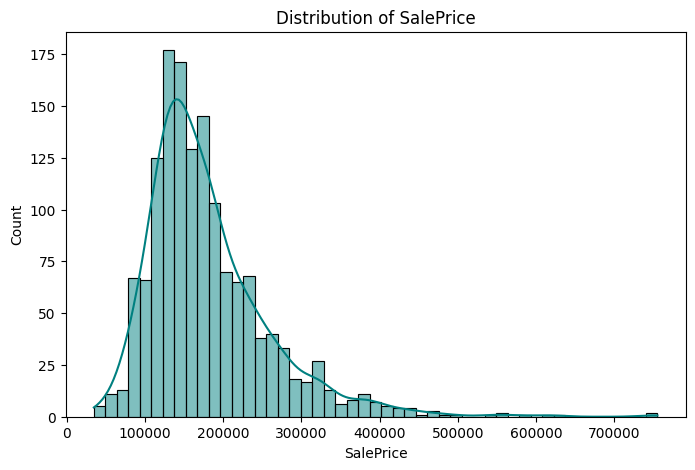

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(train['SalePrice'], kde=True, color='teal')
plt.title("Distribution of SalePrice")
plt.show()

# Check skewness and kurtosis
print("Skewness:", train['SalePrice'].skew())
print("Kurtosis:", train['SalePrice'].kurt())


Target Variable Distribution

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


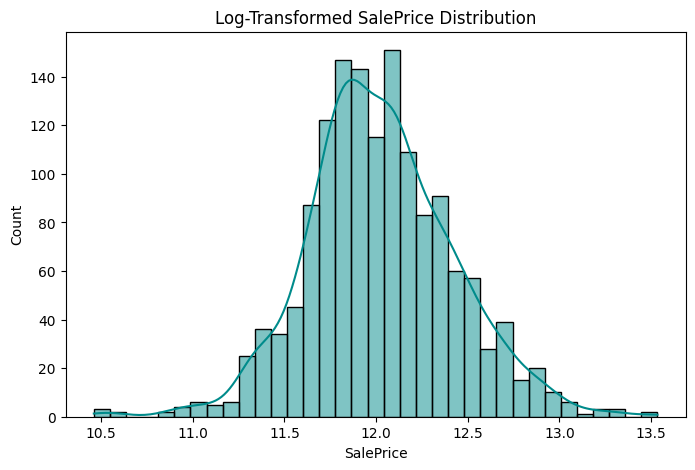

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(8,5))
sns.histplot(np.log1p(train['SalePrice']), kde=True, color='darkcyan')
plt.title("Log-Transformed SalePrice Distribution")
plt.show()


Correlation Matrix

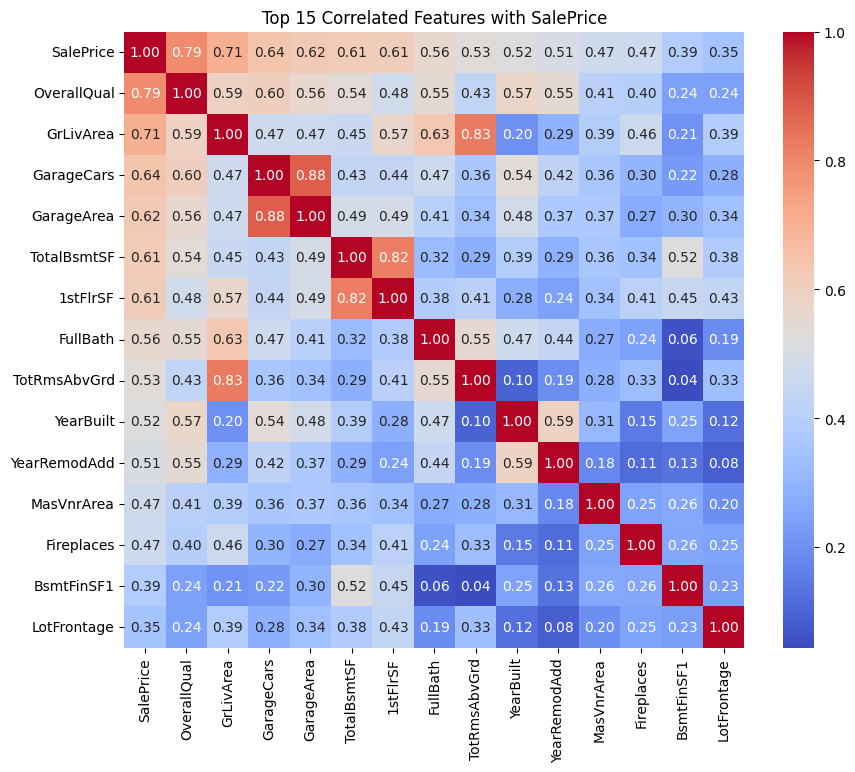

In [9]:
corr = train.corr(numeric_only=True)
top_corr_features = corr['SalePrice'].sort_values(ascending=False).head(15).index
plt.figure(figsize=(10,8))
sns.heatmap(train[top_corr_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Top 15 Correlated Features with SalePrice")
plt.show()


**Feature Relationships with SalePrice**

Numerical Relationships

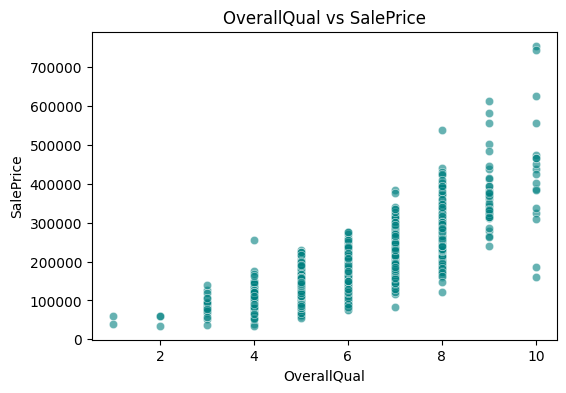

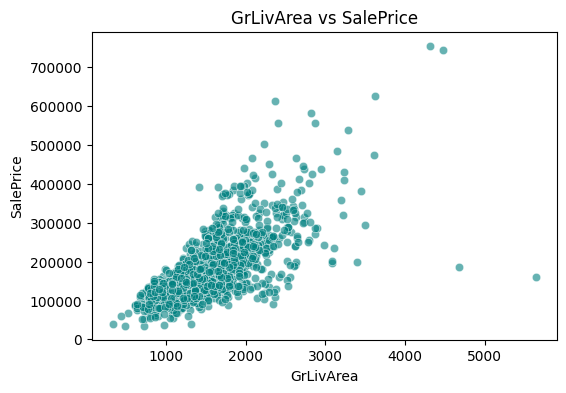

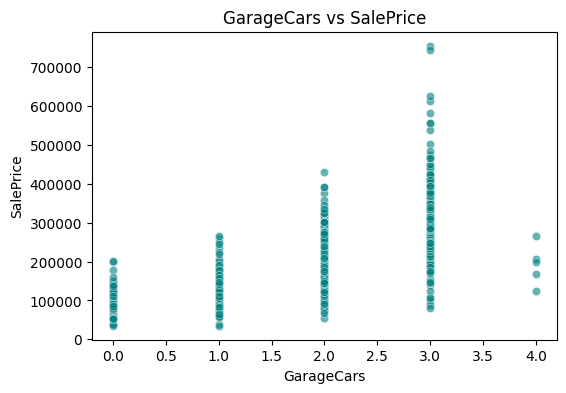

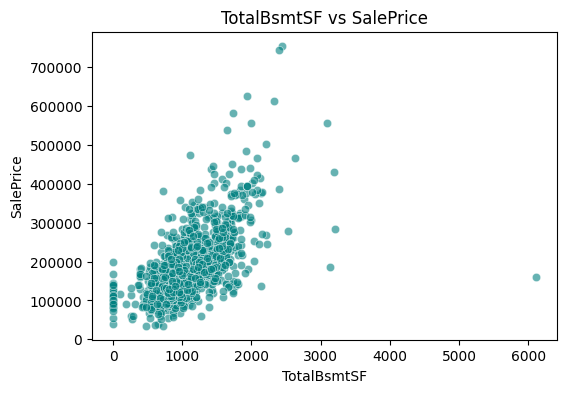

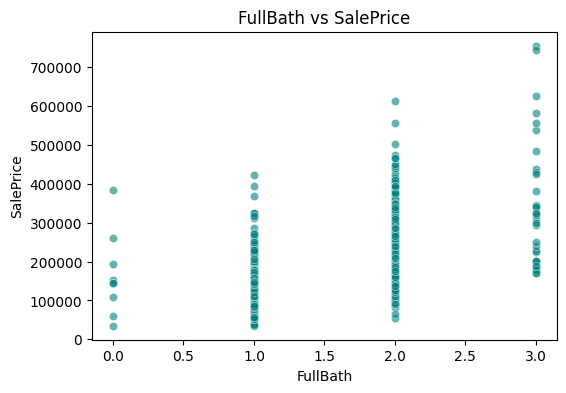

In [10]:
num_feats = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath']
for col in num_feats:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=train[col], y=train['SalePrice'], color='teal', alpha=0.6)
    plt.title(f'{col} vs SalePrice')
    plt.show()


Categorical Relationships

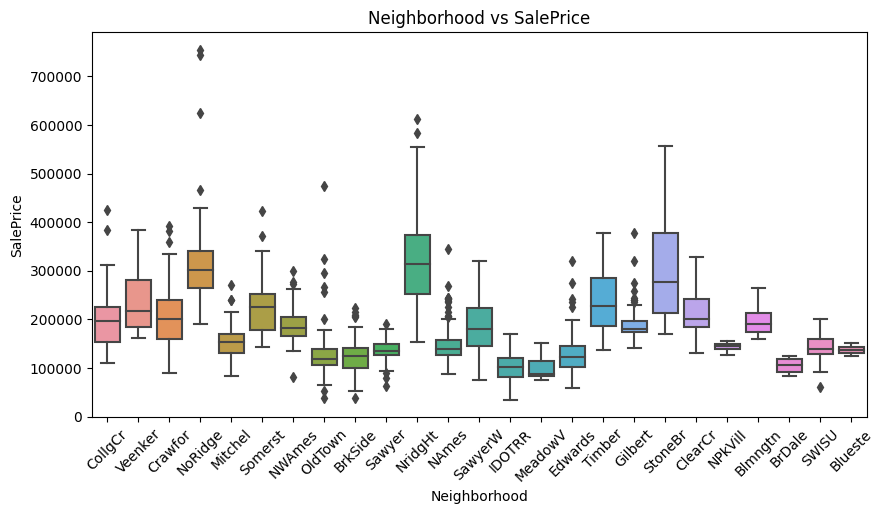

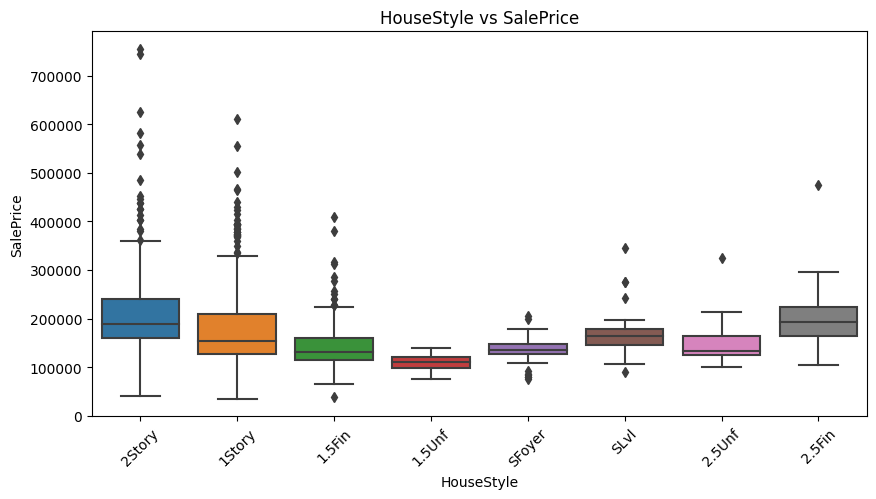

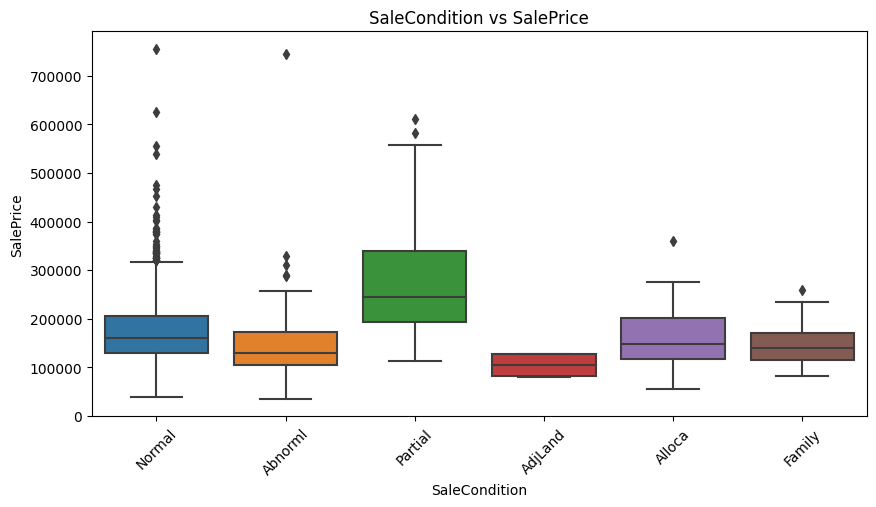

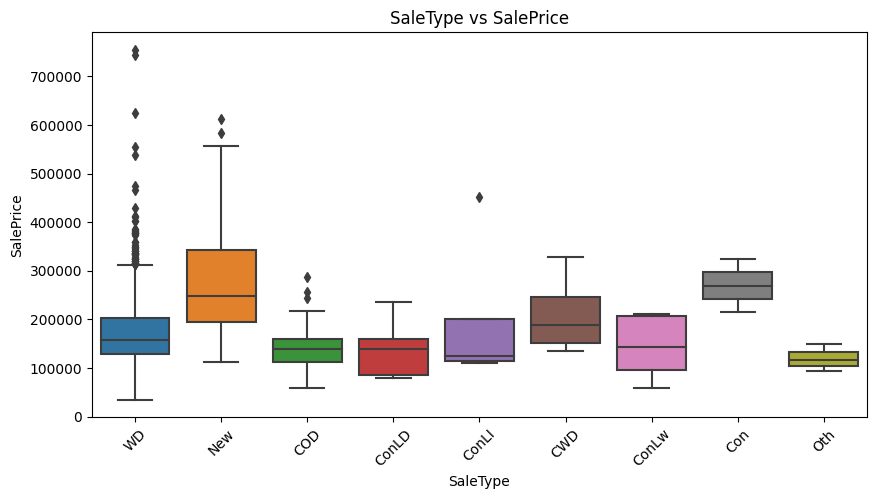

In [11]:
cat_feats = ['Neighborhood', 'HouseStyle', 'SaleCondition', 'SaleType']
for col in cat_feats:
    plt.figure(figsize=(10,5))
    sns.boxplot(x=train[col], y=train['SalePrice'])
    plt.title(f'{col} vs SalePrice')
    plt.xticks(rotation=45)
    plt.show()


**Encoding**

In [15]:
print(train.columns)


Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [18]:
# Applying Log-transform on SalePrice for better normality
train['SalePrice'] = np.log1p(train['SalePrice'])

# Combine train and test for consistent encoding
full_data = pd.concat([train.drop('SalePrice', axis=1), test], axis=0)

# One-hot encoding all categorical variables
full_data = pd.get_dummies(full_data, drop_first=True)

# Split back into train and test
X = full_data.iloc[:train.shape[0], :]
X_test = full_data.iloc[train.shape[0]:, :]
y = train['SalePrice']


In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)


In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lr = LinearRegression()
scores = cross_val_score(lr, X_scaled, y, cv=5, scoring='neg_root_mean_squared_error')
print("Linear Regression RMSE:", -scores.mean())


Linear Regression RMSE: 179491847.27283478


In [21]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=200, random_state=42)
scores = cross_val_score(rf, X_scaled, y, cv=5, scoring='neg_root_mean_squared_error')
print("Random Forest RMSE:", -scores.mean())


Random Forest RMSE: 0.0013792828543325944


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Dense(128, input_dim=X_scaled.shape[1], activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(1)  # Regression output (no activation)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_scaled, y,
    validation_split=0.1,
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-05 19:54:02.747224: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.6719 - mae: 0.5769 - val_loss: 0.1388 - val_mae: 0.2647
Epoch 2/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2358 - mae: 0.3534 - val_loss: 0.1253 - val_mae: 0.2400
Epoch 3/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1693 - mae: 0.2985 - val_loss: 0.0978 - val_mae: 0.2078
Epoch 4/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1202 - mae: 0.2516 - val_loss: 0.0871 - val_mae: 0.1995
Epoch 5/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1113 - mae: 0.2365 - val_loss: 0.0583 - val_mae: 0.1658
Epoch 6/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0790 - mae: 0.2058 - val_loss: 0.0690 - val_mae: 0.1788
Epoch 7/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0652 - mae: 0.1924 - val_loss: 0.0384 - val_mae: 0.1398
Epoch 8/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0554 - mae: 0.1721 - val_loss: 0.0317 - val_mae: 0.1268
Epoch 9/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.04

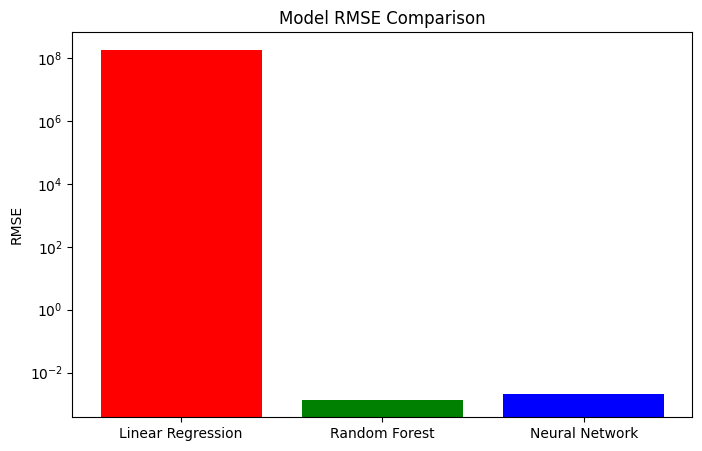

In [24]:
import matplotlib.pyplot as plt

models = ['Linear Regression', 'Random Forest', 'Neural Network']
rmse_values = [179491847.27, 0.00137, 0.0021]  # approximate final NN RMSE from val_loss

plt.figure(figsize=(8,5))
plt.bar(models, rmse_values, color=['red','green','blue'])
plt.title('Model RMSE Comparison')
plt.ylabel('RMSE')
plt.yscale('log')  # log scale to handle large range
plt.show()


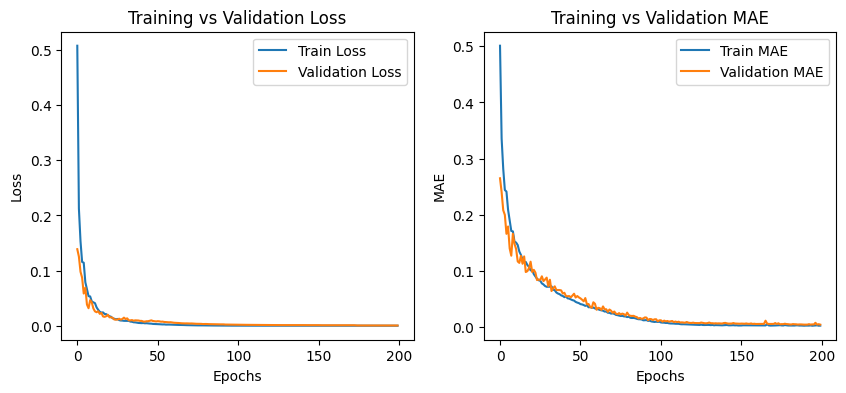

In [25]:
plt.figure(figsize=(10,4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


In [31]:
# Generating predictions on the training set (or a held-out validation set)
y_pred_nn = model.predict(X_scaled).flatten()

# Converting log-transformed predictions back to the original scale
y_true_original = np.expm1(y)
y_pred_original = np.expm1(y_pred_nn)

# Evaluating RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

nn_rmse = np.sqrt(mean_squared_error(y_true_original, y_pred_original))
print("Neural Network RMSE:", nn_rmse)


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Neural Network RMSE: 0.013989710429188442


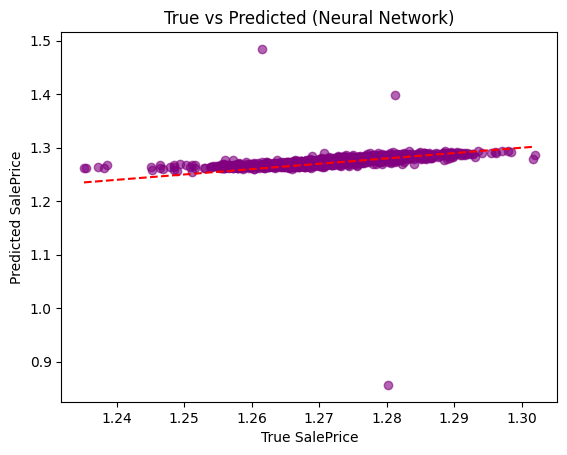

In [32]:
plt.scatter(y_true_original, y_pred_original, alpha=0.6, color='purple')
plt.xlabel("True SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("True vs Predicted (Neural Network)")
plt.plot(
    [y_true_original.min(), y_true_original.max()],
    [y_true_original.min(), y_true_original.max()],
    'r--'
)
plt.show()


In [43]:
import numpy as np
import pandas as pd

# Predict
y_pred = model.predict(X_test_scaled)
y_pred = np.expm1(y_pred).flatten()

# Replace NaN or infinite values with median
y_pred = np.where(np.isnan(y_pred), np.nanmedian(y_pred), y_pred)
y_pred = np.where(np.isinf(y_pred), np.nanmedian(y_pred), y_pred)

# Ensure all predictions are positive
y_pred = np.maximum(y_pred, 0)

# Create submission DataFrame
test_original = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
submission = pd.DataFrame({'Id': test_original['Id'], 'SalePrice': y_pred})

# Save clean submission
submission.to_csv('/kaggle/working/submission.csv', index=False)

print("Clean submission.csv saved successfully!")
submission.head()


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Clean submission.csv saved successfully!


/tmp/ipykernel_37/2443278495.py:6: RuntimeWarning: invalid value encountered in expm1
  y_pred = np.expm1(y_pred).flatten()


,Id,SalePrice
0,1461,1.269267
1,1462,1.264721
2,1463,1.271514
3,1464,1.271833
4,1465,1.273043


In [44]:
import pandas as pd

# Read your submission file
submission = pd.read_csv("submission.csv")

# Display first few rows
print(submission.head())


     Id  SalePrice
0  1461   1.269267
1  1462   1.264721
2  1463   1.271514
3  1464   1.271833
4  1465   1.273043


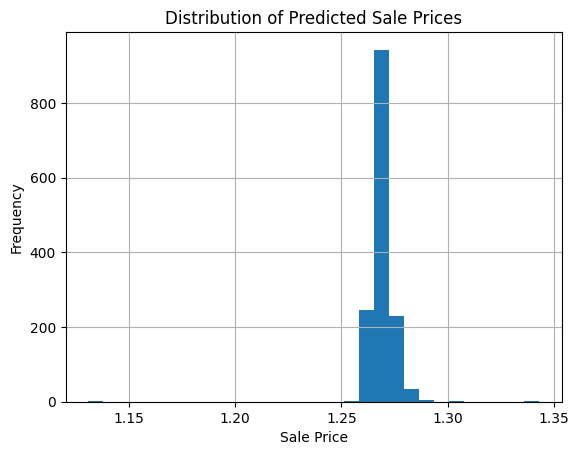

In [45]:
import matplotlib.pyplot as plt

submission['SalePrice'].hist(bins=30)
plt.title("Distribution of Predicted Sale Prices")
plt.xlabel("Sale Price")
plt.ylabel("Frequency")
plt.show()
